## An application of PnP: Head pose estimation

The primer has been adapted from https://learnopencv.com/head-pose-estimation-using-opencv-and-dlib/.

Check it out for more details.

Here we will try to find the pose of the head with respect to the camera using PnP. For this we need to select some features in image (keypoints,landmarks,etc) which are already given in this primer. After this we also need to know their 3d locations in a frame we call as world-cordinate frame. The origin of this frame can be chosen arbitarily, here its chosen on the tip of the nose as we need to find the way the head is rotated.

In [13]:
### Note this cell might take a few seconds to run the first time

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

#download image
if not os.path.exists('./headPose.jpg'):

    !wget https://learnopencv.com/wp-content/uploads/2016/09/headPose.jpg

<method-wrapper '__get__' of method object at 0x7f8478752480>

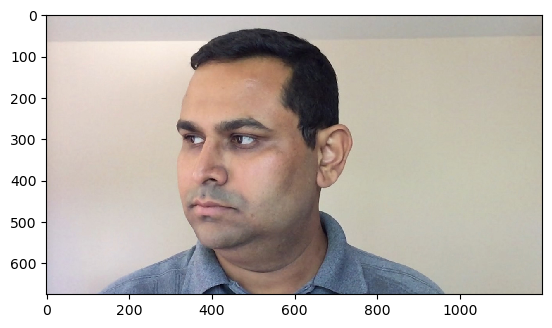

In [17]:
# Read Image
im = cv2.imread("headPose.jpg")
# cv2_imshow(im)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

imsize = im.shape

# hard-coded 2D image points. If you change the image, you need to change vector
image_points = np.array([
                            (359, 391),     # Nose tip
                            (399, 561),     # Chin
                            (337, 297),     # Left eye left corner
                            (513, 301),     # Right eye right corne
                            (345, 465),     # Left Mouth corner
                            (453, 469)      # Right mouth corner
                        ], dtype="double")

for p in image_points:
    cv2.circle(im, (int(p[0]), int(p[1])), 3, (255,0,0), -1)

These are the points selected for finding the solution to PnP. As you remember we need pixel coordinates and their corresponding world coordinates to solve the problem.

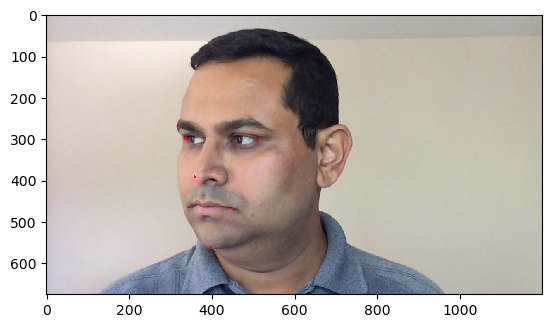

In [18]:
plt.imshow(im)

Corresponding, hard-coded 3D model points which we have measured:

In [19]:
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner

                        ])


This is the camera intrinsic matrix:

In [20]:
# Camera intrinsics matrix K

focal_length = imsize[1]
center = (imsize[1]/2, imsize[0]/2)
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )

print("Camera Matrix :\n {0}".format(camera_matrix))

Camera Matrix :
 [[1.200e+03 0.000e+00 6.000e+02]
 [0.000e+00 1.200e+03 3.375e+02]
 [0.000e+00 0.000e+00 1.000e+00]]


Now we use the OpenCv's solvePnP function which would return the rotation and traslation of chosen origin (nose tip) in camera co-ordiante system.
Remember in the extrinsic equation we use the same R,t. Here the solvePnpP returns the rotation in form of axis-angle format. You can read more about this on https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation

In [21]:
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs,flags=cv2.SOLVEPNP_ITERATIVE)

print("The estimated rotation vector of object in camera coordinate system:\n {0}".format(rotation_vector))
print("\nThe estimated translation vector of object in camera coordinate system:\n {0}".format(translation_vector))

The estimated rotation vector of object in camera coordinate system:
 [[-0.05800198]
 [ 2.20224639]
 [ 0.01942058]]

The estimated translation vector of object in camera coordinate system:
 [[  449.51968738]
 [  -94.74161089]
 [-2343.96945188]]


Now using the above R, t we project a 3D point (0, 0, 1000.0) onto the image plane. If you see this point is 0 in x,y and has 1000 in z. We chose this point such that this is a vector in direction of z starting from tip of the nose (selected origin) so this can give an idea of where our head is pointing. We will use this to draw a line sticking out of the nose. Remember without estimating this R,t we could not do this before.



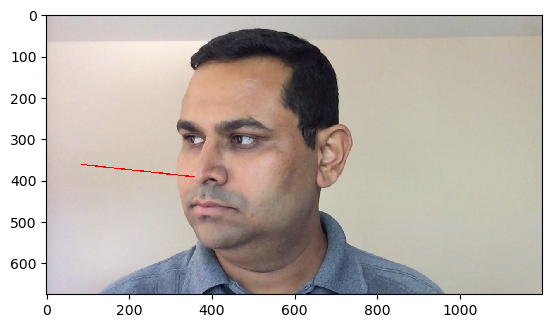

In [23]:
im = cv2.imread("headPose.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
(nose_end_point2D, _) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

p1 = ( int(image_points[0][0]), int(image_points[0][1]))
p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

cv2.line(im, p1, p2, (255,0,0), 2)

# Display image
plt.imshow(im)


For more information you can also refer to https://docs.opencv.org/4.x/d5/d1f/calib3d_solvePnP.html

## Now solving it using P3P

Remember that P3P requires 3 points only and it returns multiple solutions. A way in which we can decide the proper solution is by exploting some known physical point. Like suppose you have 4 points then you find some set of solutions using any 3 points. Then using that set of solution you backproject the world point of 4th point in image plane and now as you already knew the pixel coordinate of the 4th point. You can take the one which minimises the reprojection error. Here we are just visually finding the appropriate solution.

In [24]:
(solutions, rotation_vector,translation_vector) = cv2.solveP3P(model_points[0:3], image_points[0:3], camera_matrix,dist_coeffs,flags=cv2.SOLVEPNP_P3P)

for id in range(solutions):
  print("\nSolution {0} The estimated rotation Vector of object in camera co-ordinate system:\n {1}".format(id,rotation_vector[id]))
  print("\nSolution {0} The estimated translation vector of object in camera co-ordainte system:\n {1}".format(id,translation_vector[id]))


Solution 0 The estimated rotation Vector of object in camera co-ordinate system:
 [[ 0.98429127]
 [-0.262196  ]
 [ 2.61519684]]

Solution 0 The estimated translation vector of object in camera co-ordainte system:
 [[-468.1629345 ]
 [ 103.92828785]
 [2331.10175031]]

Solution 1 The estimated rotation Vector of object in camera co-ordinate system:
 [[-2.87206317]
 [ 0.05125408]
 [ 1.06709909]]

Solution 1 The estimated translation vector of object in camera co-ordainte system:
 [[-440.182168  ]
 [  97.71678616]
 [2191.77842743]]


Visualizing Solution 0
Visualizing Solution 1


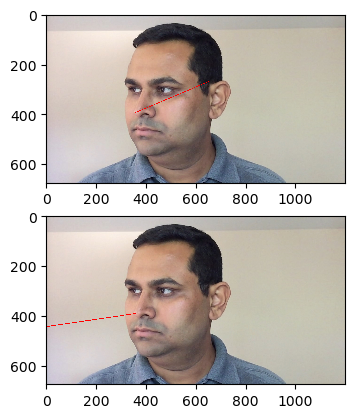

In [32]:
### You might need to scroll in this cell's output to see both images!
fig, ax = plt.subplots(2,1)
for id in range(solutions):
  print("Visualizing Solution {0}".format(id))
  im = cv2.imread("headPose.jpg")
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  (nose_end_point2D, _) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector[id], translation_vector[id], camera_matrix, dist_coeffs)

  p1 = ( int(image_points[0][0]), int(image_points[0][1]))
  p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

  cv2.line(im, p1, p2, (255,0,0), 2)

  # Display image
  
  ax[id].imshow(im)

  

Some links for more information on P3P: https://www.youtube.com/watch?v=N1aCvzFll6Q